# Ähnlichkeit von Dokumenten bestimmen

- Oft möchte man in einem grossen Corpus herausfinden welche Dokumente irgendwie ähnlich sind, dh. ähnliche Themen haben oder einfach nur ähnliche Wörter benutzen. 
- Es gibt viele komplizierte Verfahren das zu tun. Das einfachste das ich kenne ist TF-IDF. 
- Wir nutzen: ```pip install sklearn```

# TF-IDF

Wiki Sagt: Das Tf-idf-Maß (von englisch term frequency ‚Vorkommenshäufigkeit‘ und inverse document frequency ‚inverse Dokumenthäufigkeit‘) wird im Information Retrieval zur Beurteilung der Relevanz von Termen in Dokumenten einer Dokumentenkollektion eingesetzt.

Ich sage salopp:
TF-IDF Ein Maß dafür wie relevant ein Wort für ein Dokument ist. 
- TF: Wie oft kommt das Wort vor? 
- DF: Wie oft kommt Wort im Dokument vor?
- Ein Quotient daraus gibt Wörtern die "charakeristisch" für ein Dokuement sind eine "höhere" Gewichtung. 

Es ist nicht wirklich wichtig zu wissen wie genau dieses Feature bestimmt wird, es ist aber sehr praktisch beim clustern von Dokumenten. Für diejenigen die es ganz genau wissen wollen ist hier ein super Einstieg dafür: https://medium.freecodecamp.org/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3

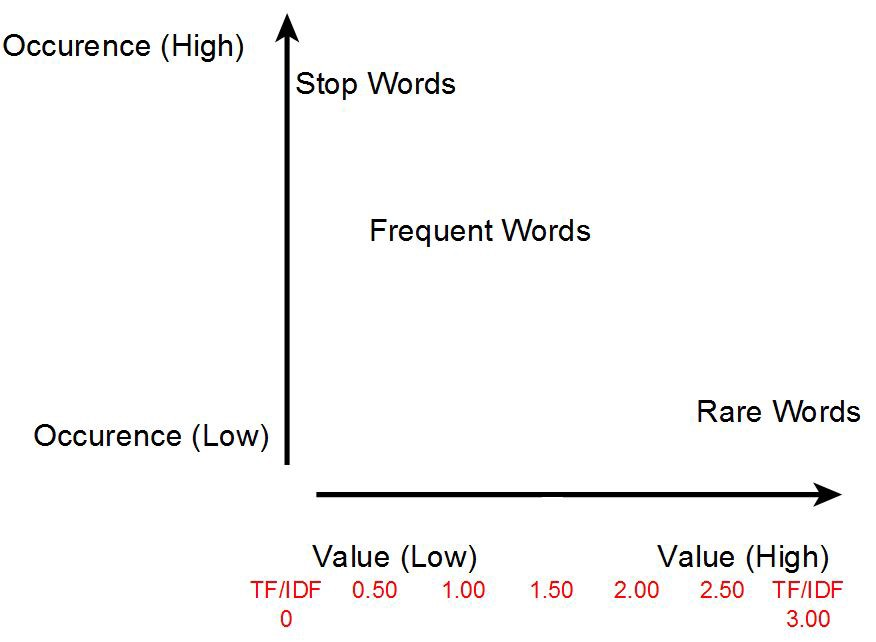

In [6]:
from IPython.display import Image
Image("tf-idf.jpeg")

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

## Beispiel für TF-IDF Werte von Wörtern

In [5]:
myvocabulary = ['life', 'learning', "cat", "the"]
corpus = {1: "The game of life is a game of everlasting learning", 2: "The unexamined life is not worth living", 3: "Never stop the learning", 4: "Life is great. Keep on the learning!", 5: "The cat crossed the street and died."}
tfidf = TfidfVectorizer(vocabulary = myvocabulary, ngram_range = (1,3))
tfs = tfidf.fit_transform(corpus.values())

feature_names = tfidf.get_feature_names()
corpus_index = [n for n in corpus]
import pandas as pd
df = pd.DataFrame(tfs.T.todense(), index=feature_names, columns=corpus_index)
tfs = tfidf.fit_transform(corpus.values())
df.T

,life,learning,cat,the
1,0.631667,0.631667,0.00000,0.449436
2,0.814802,0.000000,0.00000,0.579739
3,0.000000,0.814802,0.00000,0.579739
4,0.631667,0.631667,0.00000,0.449436
5,0.000000,0.000000,0.72391,0.689894


# Beispiel für Sätze

- Mit diesem Code lässt sich für beliebige Sätze deren "Entfernung" berechnen. 
- Man schaut wie stark sich sätze bzgl. der TF-IDF Scores der Wörter die wir analysieren ähneln. 
- Diese kann man dann nutzen um zu sehen welche Sätze ähnlich sind. 

In [11]:
vect = TfidfVectorizer(min_df=1)
corpus = ["I'd like an apple", "An apple a day keeps the doctor away", "Never compare an apple to an orange", "I prefer scikit-learn to Orange", "I went to the beach"]
tfidf = vect.fit_transform(corpus)
apples_matrix = (tfidf * tfidf.T).A
apples_matrix

array([[1.        , 0.27650494, 0.42267669, 0.        , 0.        ],
       [0.27650494, 1.        , 0.24716051, 0.        , 0.15697052],
       [0.42267669, 0.24716051, 1.        , 0.23493834, 0.11022572],
       [0.        , 0.        , 0.23493834, 1.        , 0.12582678],
       [0.        , 0.15697052, 0.11022572, 0.12582678, 1.        ]])

# Visualisierung

```pip install seaborn```

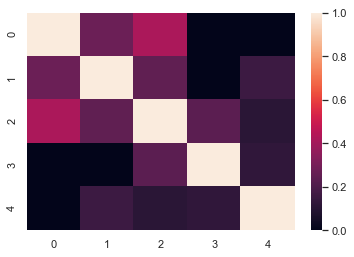

In [8]:
%matplotlib inline
import seaborn as sns; sns.set()
ax = sns.heatmap(apples_matrix)

# Beispiel für Dokumente mit Stemming und Stopword Entfernung

In [12]:
import nltk, string

text_files = ["godfather.txt", "schindlers_list.txt", "shawnshank.txt"]
documents = [open(f).read() for f in text_files]

# Stemming
stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

#Remove punctuaction, stem
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english').fit_transform(documents)

# no need to normalize, since Vectorizer will return normalized tf-idf
pairwise_similarity = vectorizer * vectorizer.T
pairwise_similarity.A

array([[1.        , 0.09018803, 0.13309666],
       [0.09018803, 1.        , 0.10352998],
       [0.13309666, 0.10352998, 1.        ]])

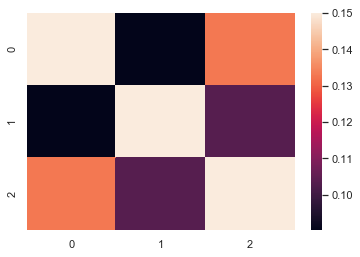

In [23]:
import seaborn as sns; sns.set()
ax = sns.heatmap(pairwise_similarity.A,vmax=0.15)

# Clustering
- Clustering ist ein statistisches Verfahren um "ähnliche" dinge zusammen in ein "Cluster" zu legen. 
- Wichtig ist dass je nach verfahren die Anzahl der Cluster definiert werden muss. Hier 3. 
- Das Clustering Verfahren das hier verwendet wird heisst k-Means (https://de.wikipedia.org/wiki/K-Means-Algorithmus)

## Für Sätze

cluster  0 :
	sentence  0 :  I like green apples
	sentence  1 :  Green apples are tasty
cluster  1 :
	sentence  0 :  Nature is beautiful
	sentence  1 :  We should protect the trees
	sentence  2 :  Fruit trees provide fruits


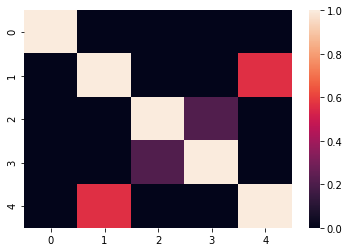

In [14]:
import collections
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
import seaborn as sns

def word_tokenizer(text):
        #tokenizes and stems the text
        tokens = word_tokenize(text)
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens if t not in stopwords.words('english')]
        return tokens


def cluster_items(items, nb_of_clusters=5,mds=False):
        tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,
                                        stop_words=stopwords.words('english'),
                                        lowercase=True)
        #builds a tf-idf matrix for the sentences
        tfidf_matrix = tfidf_vectorizer.fit_transform(items)
        
        # Show matrix
        pairwise_similarity = tfidf_matrix * tfidf_matrix.T
        ax = sns.heatmap(pairwise_similarity.A)
        ax.plot()
        
        # Clustering
        kmeans = KMeans(n_clusters=nb_of_clusters)
        kmeans.fit(tfidf_matrix)
        clusters = collections.defaultdict(list)
        for i, label in enumerate(kmeans.labels_):
                clusters[label].append(i)
        if mds:
            return [pairwise_similarity,dict(clusters)]
        else:
            return dict(clusters)


items = ["Nature is beautiful","I like green apples",
        "We should protect the trees","Fruit trees provide fruits",
        "Green apples are tasty"]

nclusters= 2
clusters = cluster_items(items, nclusters)
for cluster in range(nclusters):
        print "cluster ",cluster,":"
        for i,item in enumerate(clusters[cluster]):
                print "\tsentence ",i,": ",items[item]

## Für Textdokumente

In [7]:
text_files = ["godfather.txt", "schindlers_list.txt", "shawnshank.txt"]
items = [open(f).read() for f in text_files]

cluster  0 :
	document  0 :  godfather.txt
	document  1 :  schindlers_list.txt
cluster  1 :
	document  0 :  shawnshank.txt


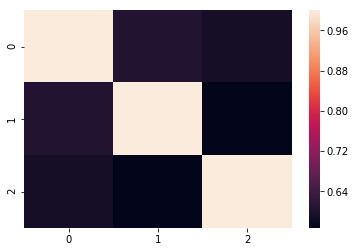

In [8]:
nclusters= 2
clusters = cluster_items(items, nclusters)
for cluster in range(nclusters):
        print "cluster ",cluster,":"
        for i,document in enumerate(clusters[cluster]):
                print "\tdocument ",i,": ",text_files[document]

## Inaugural Clustering (Multiple Text Documents)

In [10]:
from nltk.corpus import inaugural
items =[]
text_files = inaugural.fileids()
for id in inaugural.fileids():
    print(id)
    items.append((" ").join(inaugural.words(id)))

1789-Washington.txt
1793-Washington.txt
1797-Adams.txt
1801-Jefferson.txt
1805-Jefferson.txt
1809-Madison.txt
1813-Madison.txt
1817-Monroe.txt
1821-Monroe.txt
1825-Adams.txt
1829-Jackson.txt
1833-Jackson.txt
1837-VanBuren.txt
1841-Harrison.txt
1845-Polk.txt
1849-Taylor.txt
1853-Pierce.txt
1857-Buchanan.txt
1861-Lincoln.txt
1865-Lincoln.txt
1869-Grant.txt
1873-Grant.txt
1877-Hayes.txt
1881-Garfield.txt
1885-Cleveland.txt
1889-Harrison.txt
1893-Cleveland.txt
1897-McKinley.txt
1901-McKinley.txt
1905-Roosevelt.txt
1909-Taft.txt
1913-Wilson.txt
1917-Wilson.txt
1921-Harding.txt
1925-Coolidge.txt
1929-Hoover.txt
1933-Roosevelt.txt
1937-Roosevelt.txt
1941-Roosevelt.txt
1945-Roosevelt.txt
1949-Truman.txt
1953-Eisenhower.txt
1957-Eisenhower.txt
1961-Kennedy.txt
1965-Johnson.txt
1969-Nixon.txt
1973-Nixon.txt
1977-Carter.txt
1981-Reagan.txt
1985-Reagan.txt
1989-Bush.txt
1993-Clinton.txt
1997-Clinton.txt
2001-Bush.txt
2005-Bush.txt
2009-Obama.txt


cluster  0 :
	speech  0 :  1941-Roosevelt.txt
	speech  1 :  1945-Roosevelt.txt
	speech  2 :  1957-Eisenhower.txt
	speech  3 :  1961-Kennedy.txt
	speech  4 :  1965-Johnson.txt
	speech  5 :  1969-Nixon.txt
	speech  6 :  1973-Nixon.txt
	speech  7 :  1977-Carter.txt
	speech  8 :  1981-Reagan.txt
	speech  9 :  1985-Reagan.txt
	speech  10 :  1989-Bush.txt
	speech  11 :  1993-Clinton.txt
	speech  12 :  1997-Clinton.txt
	speech  13 :  2001-Bush.txt
	speech  14 :  2005-Bush.txt
	speech  15 :  2009-Obama.txt
cluster  1 :
	speech  0 :  1789-Washington.txt
	speech  1 :  1797-Adams.txt
	speech  2 :  1801-Jefferson.txt
	speech  3 :  1805-Jefferson.txt
	speech  4 :  1809-Madison.txt
	speech  5 :  1813-Madison.txt
	speech  6 :  1817-Monroe.txt
	speech  7 :  1821-Monroe.txt
	speech  8 :  1825-Adams.txt
	speech  9 :  1829-Jackson.txt
	speech  10 :  1833-Jackson.txt
	speech  11 :  1837-VanBuren.txt
	speech  12 :  1841-Harrison.txt
	speech  13 :  1845-Polk.txt
	speech  14 :  1849-Taylor.txt
	speech  15 : 

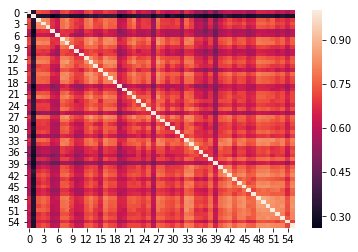

In [11]:
nclusters= 3
clusters = cluster_items(items, nclusters)
for cluster in range(nclusters):
        print "cluster ",cluster,":"
        for i,document in enumerate(clusters[cluster]):
                print "\tspeech ",i,": ",text_files[document]

Am Ende bleibt der "human touch" und ein wichtige offene Fragen:
 - Wieviele Cluster möchtet Ihr haben? Das bestimmt Ihr!
 - Wie gut lassen sich eigentlich die Dokumente separieren? (siehe Heatmap)
 - Wie sensitiv ist das Clustering, dh. wenn es mehrmals ausgeführt wird, oder sich die Daten leicht ändern, ändert sich auch das Resultat?

## Multidimensional Scaling für Inaugural Speech
- Um ein Gefühl dafür zu bekommen wie die Daten geclustert als Punktewolke in 2D daliegen, kann man ein Verfahren nutzen dass sich Multidimensional Scaling nennt. Es versucht die Pairwise Distances so zu Layouten, dass Dokumente die nahe beieinander sind auch nebeneinander liegen.
- Doku hier: https://scikit-learn.org/stable/modules/manifold.html#multi-dimensional-scaling-mds

cluster  0 :
	speech  0 :  1941-Roosevelt.txt
	speech  1 :  1945-Roosevelt.txt
	speech  2 :  1957-Eisenhower.txt
	speech  3 :  1961-Kennedy.txt
	speech  4 :  1965-Johnson.txt
	speech  5 :  1969-Nixon.txt
	speech  6 :  1973-Nixon.txt
	speech  7 :  1977-Carter.txt
	speech  8 :  1981-Reagan.txt
	speech  9 :  1985-Reagan.txt
	speech  10 :  1989-Bush.txt
	speech  11 :  1993-Clinton.txt
	speech  12 :  1997-Clinton.txt
	speech  13 :  2001-Bush.txt
	speech  14 :  2005-Bush.txt
	speech  15 :  2009-Obama.txt
cluster  1 :
	speech  0 :  1789-Washington.txt
	speech  1 :  1797-Adams.txt
	speech  2 :  1801-Jefferson.txt
	speech  3 :  1805-Jefferson.txt
	speech  4 :  1809-Madison.txt
	speech  5 :  1813-Madison.txt
	speech  6 :  1817-Monroe.txt
	speech  7 :  1821-Monroe.txt
	speech  8 :  1825-Adams.txt
	speech  9 :  1829-Jackson.txt
	speech  10 :  1833-Jackson.txt
	speech  11 :  1837-VanBuren.txt
	speech  12 :  1841-Harrison.txt
	speech  13 :  1845-Polk.txt
	speech  14 :  1849-Taylor.txt
	speech  15 : 

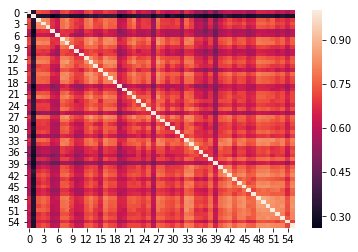

In [22]:
# Einlesen
from nltk.corpus import inaugural
items =[]
text_files = inaugural.fileids()
for id in inaugural.fileids():
    #print(id)
    items.append((" ").join(inaugural.words(id)))
    
# Clustern
nclusters= 3
pairwise_distances, clusters = cluster_items(items, nclusters,True)
for cluster in range(nclusters):
        print "cluster ",cluster,":"
        for i,document in enumerate(clusters[cluster]):
                print "\tspeech ",i,": ",text_files[document]

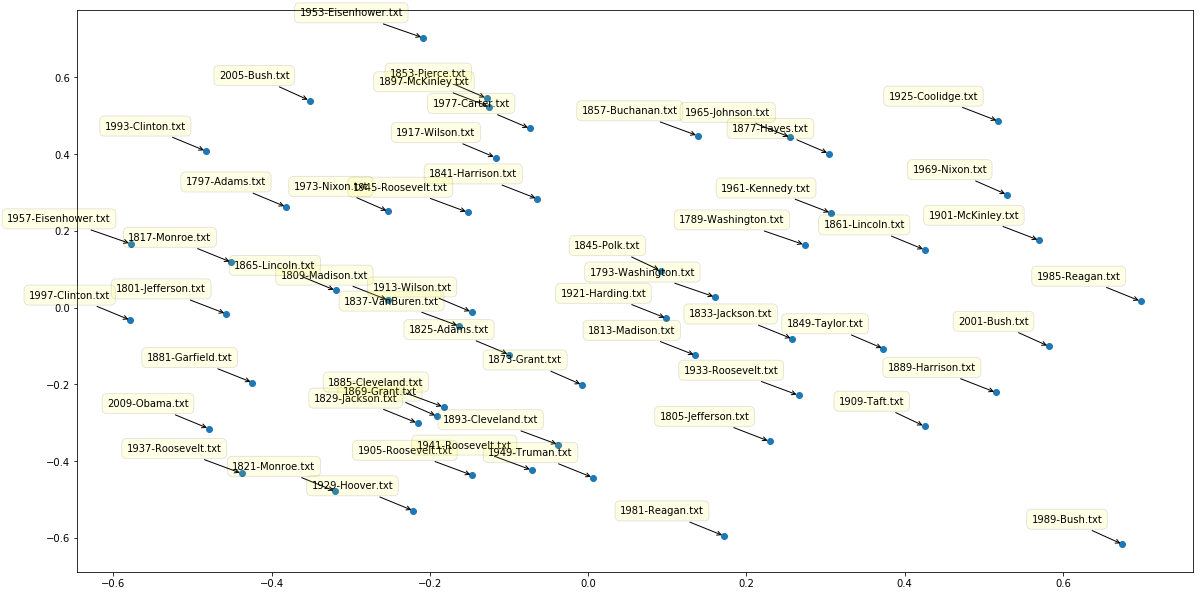

In [26]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6, metric=False)
results = mds.fit(pairwise_distances.A)

coords = results.embedding_

plt.figure(figsize=(20,10))
plt.subplots_adjust(bottom = 0.1)
plt.scatter(coords[:, 0], coords[:, 1], marker = 'o')

for label, x, y in zip(text_files, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.1),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()


- Ihr seht dass die Texte keine wirklichen "Cluster" bilden, dh. Punktewolken bei denen Texte sehr nahe beieinander liegen, das ist ein Hinweis drauf dass man die Texte eher schwer clustern kann. 